In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

In [2]:
# select the data
def select_data(data, start=2016, end=2024, columns=None):
    # convert the data to a pandas dataframe
    data['Date'] = pd.to_datetime(data['Date'])
    # create a mask for the data
    mask = (data['Date'].dt.year >= start) & (data['Date'].dt.year <= end)
    # select the data
    data = data.loc[mask]
    if columns is not None:
        data = data[columns]
    else:
        # drop the date column
        data = data.drop(columns='Date')
    return data

In [3]:
def prepare_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), :]
        X.append(a)
        Y.append(dataset[i + look_back, :])
    return np.array(X), np.array(Y)

In [4]:
def create_scaler(dataset):
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)
    return scaler, dataset 
def to_scalar(scaler, data):
    return scaler.transform(data)

In [5]:
def create_model(dataset, look_back=1, epochs=100, batch_size=1, verbose=1):
    X, Y = prepare_dataset(dataset, look_back)
    X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))
    Y = np.reshape(Y, (Y.shape[0], Y.shape[1]))
    
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
    model.add(Dropout(0.1))
    model.add(LSTM(units=50))
    model.add(Dense(X.shape[2]))  # Assuming single feature for simplicity
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X, Y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    
    return model

In [6]:
# declare the path of the data
path_to_data = "data/data_mean.csv"

# load the data
# import pandas as pd
data = pd.read_csv(path_to_data)

col=['Rice', 'Wheat', 'Atta (Wheat)', 'Gram Dal', 'Tur/Arhar Dal']

# select the desired data
req_data = select_data(data=data, start=2020, end=2024, columns=col)
print(req_data.shape)

(1716, 5)


In [7]:
# split the data into training and testing
train_size = int(len(req_data) * 0.80)
test_size = len(req_data) - train_size
train, test = req_data[0:train_size], req_data[train_size:len(req_data)]

In [8]:
# scale the data
scaler, train_scaler = create_scaler(train) # scaled_data is a numpy array

In [9]:
# set the look back
look_back = 28
# create the model
myModel = create_model(train_scaler, look_back, epochs=50, batch_size=1, verbose=1)

Epoch 1/50


c:\Users\krish\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1344/1344 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0092
Epoch 2/50
1344/1344 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0032
Epoch 3/50
1344/1344 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0027
Epoch 4/50
1344/1344 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0028
Epoch 5/50
1344/1344 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0023
Epoch 6/50
1344/1344 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0025
Epoch 7/50
1344/1344 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0025
Epoch 8/50
1344/1344 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0024
Epoch 9/50
1344/1344 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0027
Epoch 10/50
1344/1344 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0022
Epoch 11/50
1344/1344 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0020
Epoch 12/50
1344/1344 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0021
Epoch 13/50
1344/1344 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0022
Epoch 14/50
1344/1344 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0021
Epoch 15/50
1344/1344 ━━━━━━━━━━━━━━━━━

In [10]:
# prepare test data
# convert to scaler
test_scalar = scaler.transform(test)
# split features and outcome
x_test, y_test = prepare_dataset(test_scalar, look_back)

In [11]:
x_train, y_train = prepare_dataset(train_scaler, look_back)

In [12]:
# predict the results
test_pred_scalar = myModel.predict(x_test)
train_pred_scalar = myModel.predict(x_train)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [13]:
# invert the predictions
test_pred = scaler.inverse_transform(test_pred_scalar)
train_pred = scaler.inverse_transform(train_pred_scalar)

# invert the actual values
y_test = scaler.inverse_transform(y_test)
y_train = scaler.inverse_transform(y_train)

In [14]:
# print the results dataframes first 5 rows
print(pd.DataFrame(train_pred).head())
print(pd.DataFrame(y_train).head())
print(pd.DataFrame(test_pred).head())
print(pd.DataFrame(y_test).head())

           0          1          2          3          4
0  43.679562  36.156517  36.085083  69.141815  94.352814
1  43.583847  36.130116  36.081085  69.412659  94.741127
2  43.537495  36.087936  36.089069  69.621124  94.952736
3  43.621590  36.083103  36.127430  69.513939  94.768745
4  43.754471  36.126987  36.119823  69.331024  94.515816
       0      1      2      3      4
0  43.33  36.11  36.00  69.78  94.33
1  43.33  36.11  36.00  69.56  94.44
2  43.33  36.11  36.00  69.56  94.44
3  43.56  36.22  36.00  69.56  94.33
4  43.71  36.29  35.86  70.29  94.14
           0          1          2          3           4
0  56.121681  44.103825  52.833900  85.168228  172.043777
1  56.364967  44.151676  52.930573  86.214020  174.535950
2  56.304184  44.200623  52.882858  86.251373  174.744812
3  56.376122  44.111870  52.816074  85.714317  173.812592
4  56.245556  44.047226  52.729019  85.939949  173.938736
       0      1      2      3       4
0  56.70  44.64  53.03  87.50  176.23
1  56.77  44

In [15]:
# print the shape of the data
print(y_test.shape)
print(test_pred.shape)
print(y_train.shape)
print(train_pred.shape)

(316, 5)
(316, 5)
(1344, 5)
(1344, 5)


In [16]:
# print shape of test and train data
print(test.shape)
print(train.shape)

(344, 5)
(1372, 5)


In [20]:
myScaler = scaler
# myModel


In [21]:
print(data.head())

   Day  Month  Year  Rice  Wheat  Atta (Wheat)  Gram Dal  Tur/Arhar Dal  \
0    1      1  2016  29.5  30.50         26.67     70.50          155.0   
1    2      1  2016  29.6  31.40         27.50     71.40          154.6   
2    3      1  2016  29.6  31.40         27.50     71.40          154.0   
3    4      1  2016  29.6  31.40         27.50     71.40          151.6   
4    5      1  2016  29.5  31.75         27.50     71.75          151.5   

        Date  
0 2016-01-01  
1 2016-01-02  
2 2016-01-03  
3 2016-01-04  
4 2016-01-05  


In [40]:
def predict_date(data, date, model, scaler, look_back):
    # convert the date to datetime
    date = pd.to_datetime(date)
    data['Date'] = pd.to_datetime(data['Date'])
    cols = ['Rice', 'Wheat', 'Atta (Wheat)', 'Gram Dal', 'Tur/Arhar Dal']
    # get the start and end date of the data
    start_date = data['Date'].min()
    end_date = data['Date'].max()
    # if date is before or same as the last date in the data then return data on that date
    if start_date <= date <= end_date:
        return data[data['Date'] == date][cols]
    elif date > end_date:
        # get the last look_back days of data
        last_data = data.tail(look_back)
        # get the required columns
        last_data = last_data[cols]
        # scale the data
        last_data = scaler.transform(last_data)
        # create a loop starting from the end_date to the date
        while end_date < date:
            # prepare the data
            x, _ = prepare_dataset(last_data, look_back)
            x = np.reshape(x, (x.shape[0], x.shape[1], x.shape[2]))
            # predict the data
            pred = model.predict(x)
            # append the prediction to the last_data
            last_data = np.append(last_data, pred, axis=0)
            last_data = last_data[-look_back:]
            # increment the end_date
            end_date = end_date + pd.DateOffset(days=1)
        # invert the prediction
        pred = scaler.inverse_transform(pred)
        return pred



In [41]:
# predict the price of the commodities on 2024-01-31
date = '2024-12-31'
result = predict_date(data, date, myModel, myScaler, look_back)
print(result)

IndexError: tuple index out of range

In [17]:
# import the evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# calculate the evaluation metrics for train data
train_mae = mean_absolute_error(y_train, train_pred)
train_mse = mean_squared_error(y_train, train_pred)
train_r2 = r2_score(y_train, train_pred)

# calculate the evaluation metrics for test data
test_mae = mean_absolute_error(y_test, test_pred)
test_mse = mean_squared_error(y_test, test_pred)
test_r2 = r2_score(y_test, test_pred)

# create a dataframe to display the results
results = pd.DataFrame({
    'Dataset': ['Train', 'Test'],
    'Mean Absolute Error': [train_mae, test_mae],
    'Mean Squared Error': [train_mse, test_mse],
    'R2 Score': [train_r2, test_r2]
})

# print the results
print(results)


  Dataset  Mean Absolute Error  Mean Squared Error  R2 Score
0   Train             0.674630            1.122693  0.957456
1    Test             2.494729           11.127733 -1.145935


In [18]:
# create a function to calculate the accuracy
def calculate_accuracy(y_true, y_pred):
    # calculate the percentage error
    error = np.abs((y_true - y_pred) / y_true) * 100
    # calculate the accuracy
    accuracy = 100 - np.mean(error, axis=0)
    return accuracy

# calculate the accuracy for train data
train_accuracy = calculate_accuracy(y_train, train_pred)
# calculate the accuracy for test data
test_accuracy = calculate_accuracy(y_test, test_pred)

# create a dataframe to display the results
results = pd.DataFrame({
    'Dataset': ['Train', 'Test'],
    'Accuracy': [train_accuracy.mean(), test_accuracy.mean()]
})

# print the results
print(results)


  Dataset   Accuracy
0   Train  98.971298
1    Test  96.891682


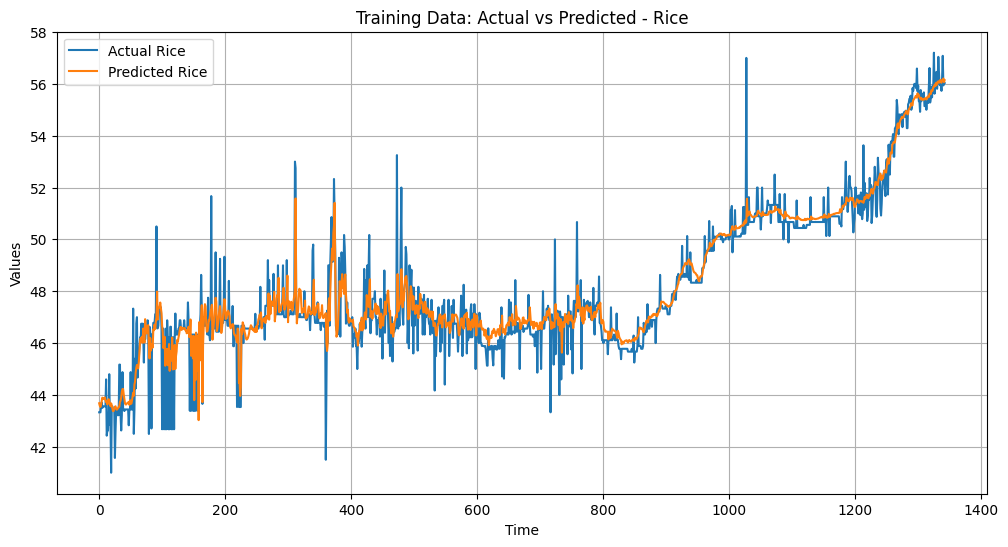

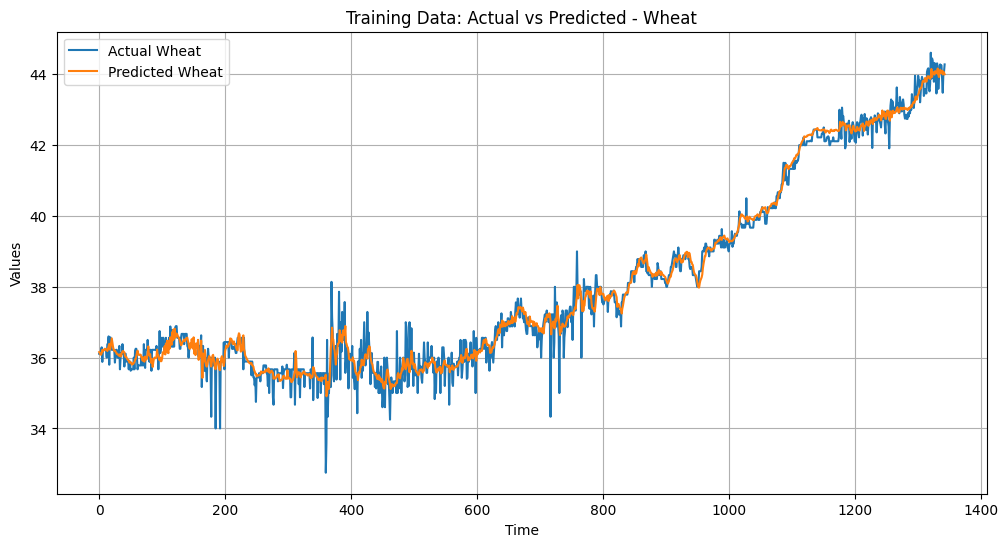

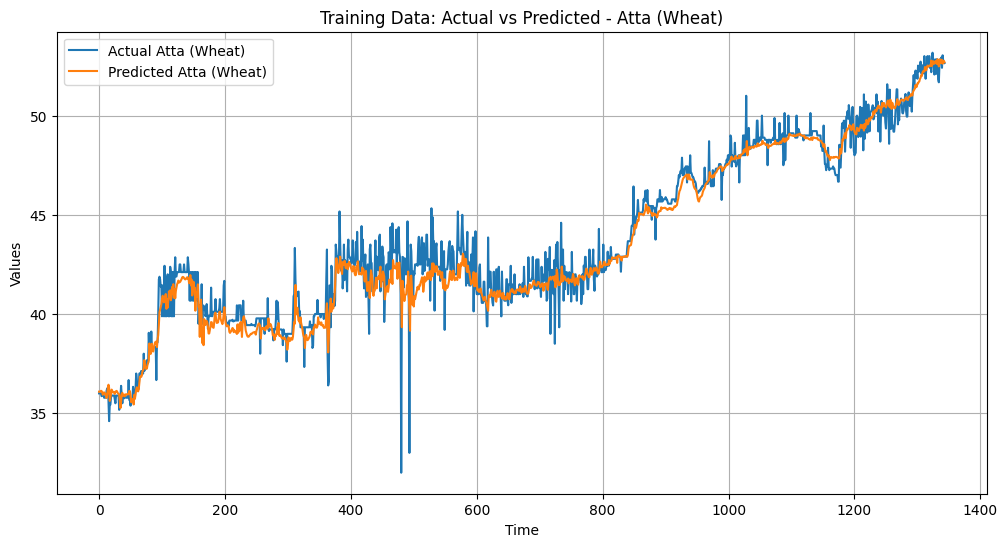

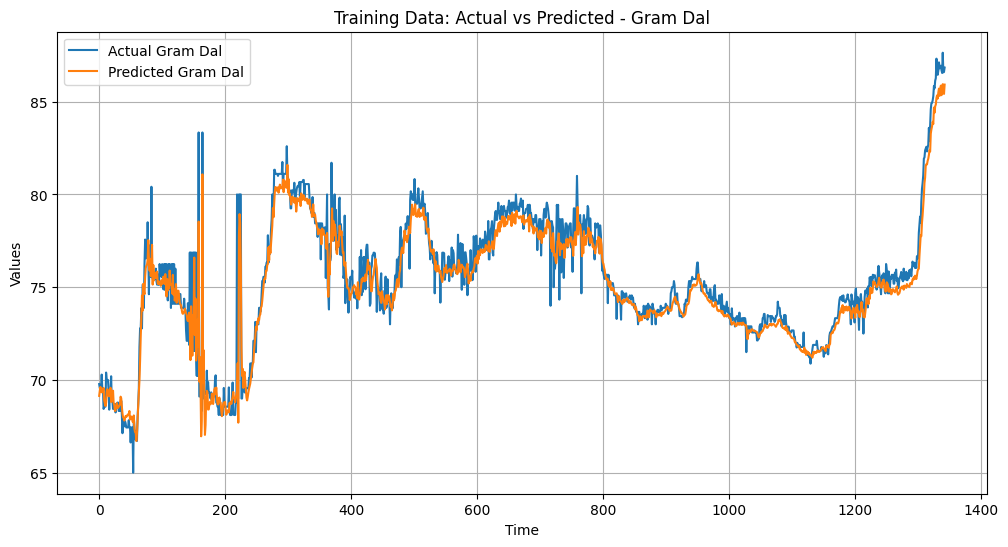

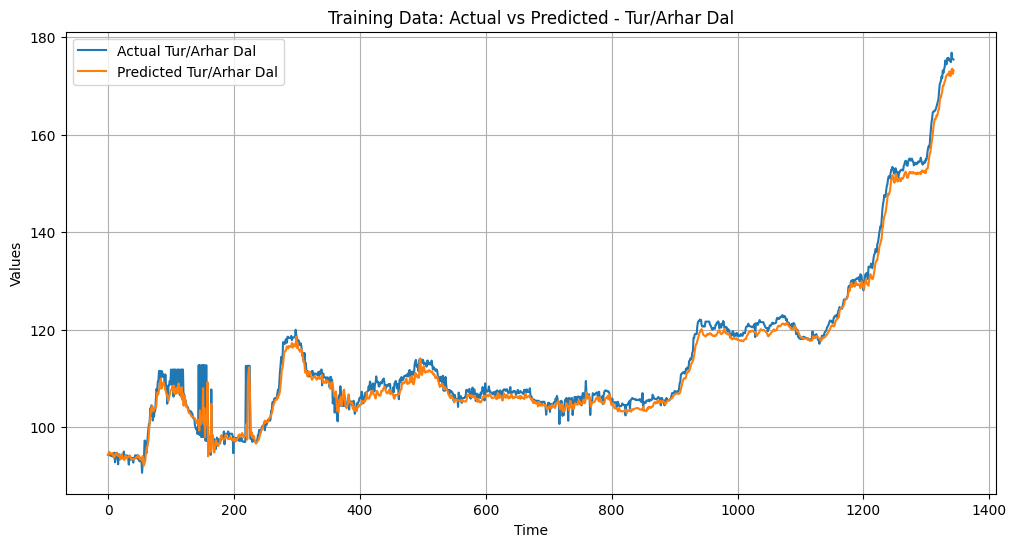

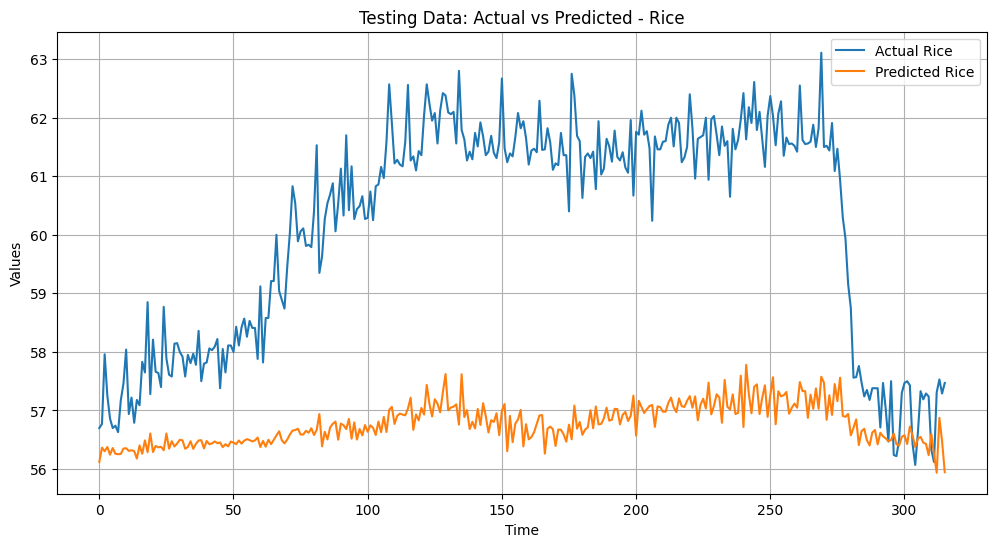

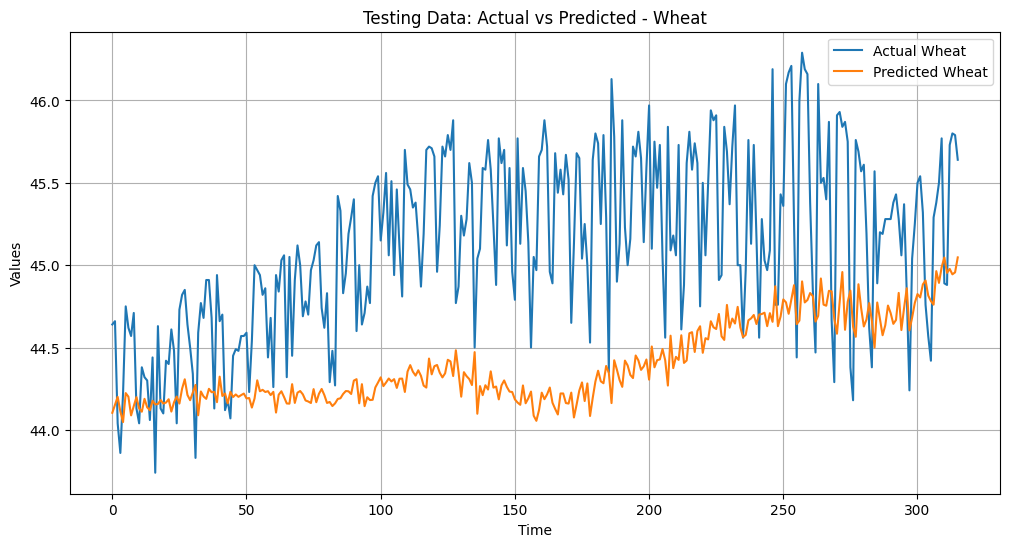

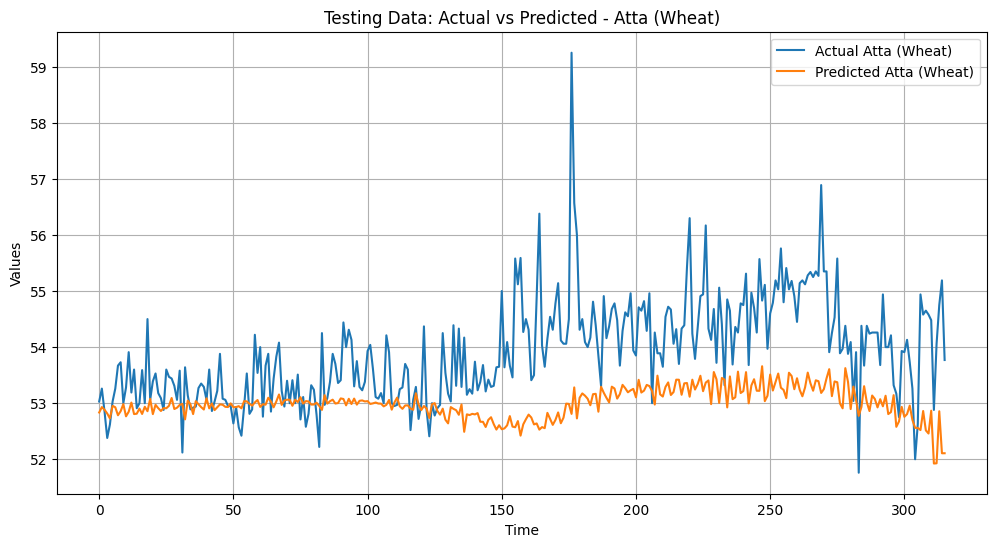

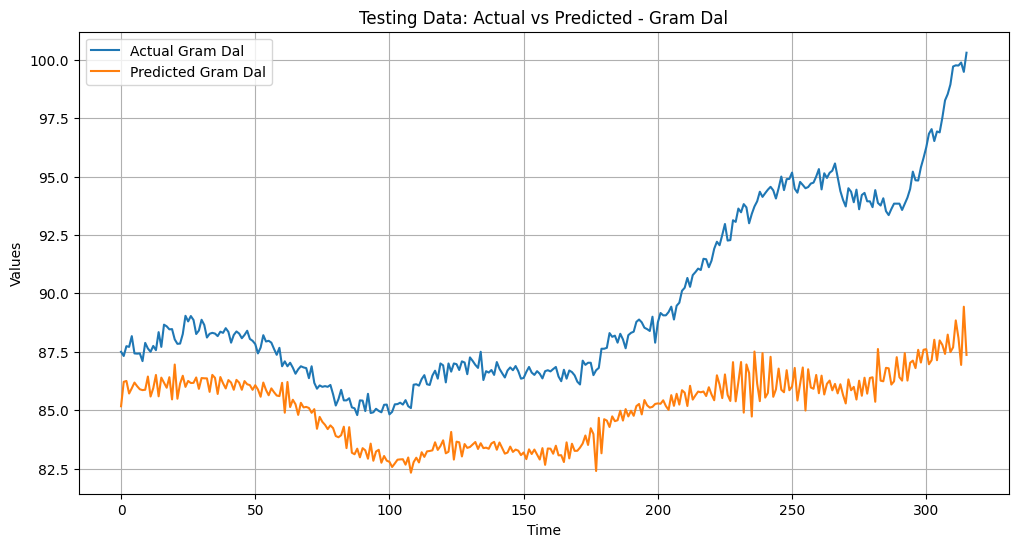

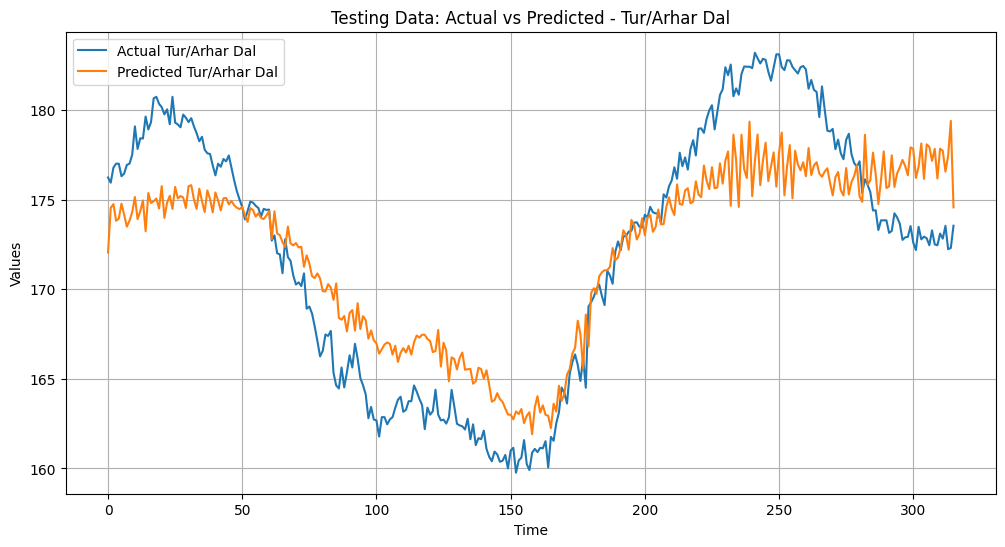

In [19]:
# plot the predictions
import matplotlib.pyplot as plt

def plot_predictions(y_true, y_pred, columns, title):
    for i, column in enumerate(columns):
        plt.figure(figsize=(12, 6))
        plt.plot(y_true[:, i], label=f'Actual {column}')
        plt.plot(y_pred[:, i], label=f'Predicted {column}')
        plt.title(f'{title} - {column}')
        plt.xlabel('Time')
        plt.ylabel('Values')
        plt.legend()
        plt.grid(True)
        plt.show()

# column names
columns = ['Rice', 'Wheat', 'Atta (Wheat)', 'Gram Dal', 'Tur/Arhar Dal']

# plot y_train and train_pred
plot_predictions(y_train, train_pred, columns, 'Training Data: Actual vs Predicted')

# plot y_test and test_pred
plot_predictions(y_test, test_pred, columns, 'Testing Data: Actual vs Predicted')
